In [1]:
import glob
import os
import pathlib
import parse_um_atmos_results as pur
import plot_pandas_data as ppd
import plot_right_axis_time as pra
from convert_time import days_to_gregorian_years, gregorian_years_to_days

In [2]:
um_atmos_archive_dir = pathlib.PurePath("../access-cm2/cm2_test/archive/")
work_dir_glob = os.path.join(um_atmos_archive_dir, "work.*.bench")
work_dir_list = glob.glob(work_dir_glob)

In [3]:
df = pur.parse_all(work_dir_list)
df1 = df[df["omp_num_threads"] == 1]
df2 = df[df["omp_num_threads"] == 2]
o0 = lambda d: d[d["ocn_npes"] == 64]
o1 = lambda d: d[d["ocn_npes"] == 128]
o2 = lambda d: d[d["ocn_npes"] == 256]

In [4]:
xticks_ncpus = lambda d: d["ncpus"].sort_values().unique()
xticks_npes  = lambda d: d["npes"].sort_values().unique()

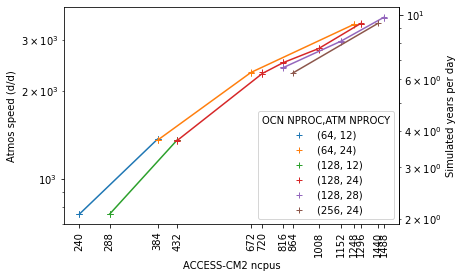

In [5]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="ACCESS-CM2 ncpus",
    ylabel="Atmos speed (d/d)",
    xticks=xticks_ncpus(df1),               
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OCN NPROC,ATM NPROCY")

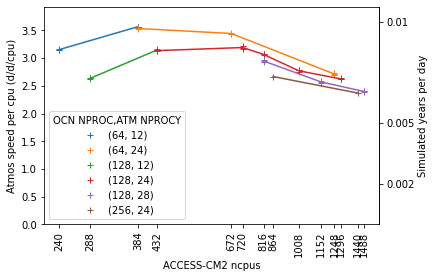

In [6]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="ACCESS-CM2 ncpus",
    ylabel="Atmos speed per cpu (d/d/cpu)",
    xticks=xticks_ncpus(df1),               
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OCN NPROC,ATM NPROCY")

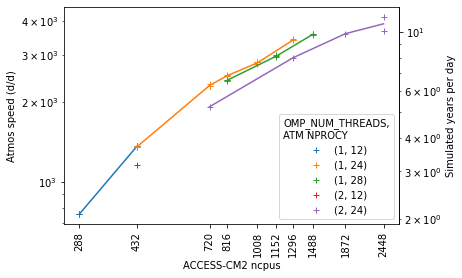

In [7]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="ACCESS-CM2 ncpus",
    ylabel="Atmos speed (d/d)",
    xticks=xticks_ncpus(o1(df)),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OMP_NUM_THREADS,\nATM NPROCY")

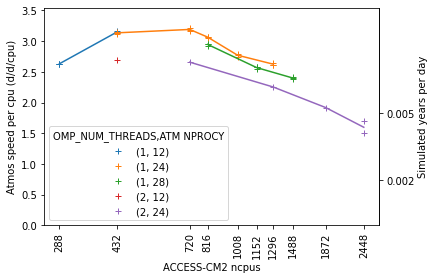

In [8]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="ACCESS-CM2 ncpus",
    ylabel="Atmos speed per cpu (d/d/cpu)",
    xticks=xticks_ncpus(o1(df)),               
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OMP_NUM_THREADS,ATM NPROCY")

In [9]:
mean_speed=dict()
group_cols=o1(df1).groupby("atm_cols")
for name, group in group_cols:
    means = group.groupby("npes")["Atm_Step_4A (AS) speed"].mean()
    mean_speed[name] = means
speed_24x12=round(mean_speed[24][288]/mean_speed[12][288],3)
speed_24x28=round(mean_speed[28][672]/mean_speed[24][672],3)
print(speed_24x12, speed_24x28)

0.995 0.961


In [10]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [11]:
df.sort_values(["omp_num_threads","ocn_npes","npes","atm_cols"])

,service_units,ncpus,cpu_seconds,memory,walltime,jobfs,omp_num_threads,nbr_time_steps,seconds_per_time_step,exp_seconds,npes,atm_rows,atm_cols,ocn_npes,ocn_rows,ocn_cols,U_MODEL_4A,Atm_Step_4A (AS),AS Atmos_Phys1 (AP1),UKCA_MAIN1,AS Atmos_Phys2 (AP2),COSP,AP1 Radiation (AP1R),AS S-L Advect (AA),AS Solver,UKCA AEROSOL MODEL,AP2 Convection,AP1R LW Rad,AP1 Microphys (AP1M),EG_CORRECT_TRACERS,AP1M LS Rain,AA SL_Tracer,AP1R SW Rad,AP2 Boundary Layer,AA SL_Full_Wind,AP2 Implicit BL,UKCA CHEMISTRY MODEL,INITIAL,AA SL_Moisture,AP2 Explicit BL,AP1 G-wave drag,AA SL_Rho,EG_CORRECT_MOISTURE,AS End TStep Diags,AA SL_Thermo,TIMER,AS STASH,AP1M LS Cloud,AS Aerosol Modelling,AS Diffusion,AS Assimilation,AP1 NI_methox,AS Energy mass,AP1 Energy Correct.,AP2 Conv Eng Corr,AP1 Conv Eng Corr,AS IAU,AS Stochastic_Phys,U_MODEL_4A * ncpus,Atm_Step_4A (AS) * ncpus,AS Atmos_Phys1 (AP1) * ncpus,UKCA_MAIN1 * ncpus,AS Atmos_Phys2 (AP2) * ncpus,COSP * ncpus,AP1 Radiation (AP1R) * ncpus,AS S-L Advect (AA) * ncpus,AS Solver * ncpus,UKCA AEROSOL MODEL * ncpus,AP2 Convection * ncpus,AP1R LW Rad * ncpus,AP1 Microphys (AP1M) * ncpus,EG_CORRECT_TRACERS * ncpus,AP1M LS Rain * ncpus,AA SL_Tracer * ncpus,AP1R SW Rad * ncpus,AP2 Boundary Layer * ncpus,AA SL_Full_Wind * ncpus,AP2 Implicit BL * ncpus,UKCA CHEMISTRY MODEL * ncpus,INITIAL * ncpus,AA SL_Moisture * ncpus,AP2 Explicit BL * ncpus,AP1 G-wave drag * ncpus,AA SL_Rho * ncpus,EG_CORRECT_MOISTURE * ncpus,AS End TStep Diags * ncpus,AA SL_Thermo * ncpus,TIMER * ncpus,AS STASH * ncpus,AP1M LS Cloud * ncpus,AS Aerosol Modelling * ncpus,AS Diffusion * ncpus,AS Assimilation * ncpus,AP1 NI_methox * ncpus,AS Energy mass * ncpus,AP1 Energy Correct. * ncpus,AP2 Conv Eng Corr * ncpus,AP1 Conv Eng Corr * ncpus,AS IAU * ncpus,AS Stochastic_Phys * ncpus,U_MODEL_4A * npes,Atm_Step_4A (AS) * npes,AS Atmos_Phys1 (AP1) * npes,UKCA_MAIN1 * npes,AS Atmos_Phys2 (AP2) * npes,COSP * npes,AP1 Radiation (AP1R) * npes,AS S-L Advect (AA) * npes,AS Solver * npes,UKCA AEROSOL MODEL * npes,AP2 Convection * npes,AP1R LW Rad * npes,AP1 Microphys (AP1M) * npes,EG_CORRECT_TRACERS * npes,AP1M LS Rain * npes,AA SL_Tracer * npes,AP1R SW Rad * npes,AP2 Boundary Layer * npes,AA SL_Full_Wind * npes,AP2 Implicit BL * npes,UKCA CHEMISTRY MODEL * npes,INITIAL * npes,AA SL_Moisture * npes,AP2 Explicit BL * npes,AP1 G-wave drag * npes,AA SL_Rho * npes,EG_CORRECT_MOISTURE * npes,AS End TStep Diags * npes,AA SL_Thermo * npes,TIMER * npes,AS STASH * npes,AP1M LS Cloud * npes,AS Aerosol Modelling * npes,AS Diffusion * npes,AS Assimilation * npes,AP1 NI_methox * npes,AS Energy mass * npes,AP1 Energy Correct. * npes,AP2 Conv Eng Corr * npes,AP1 Conv Eng Corr * npes,AS IAU * npes,AS Stochastic_Phys * npes,U_MODEL_4A per time step,Atm_Step_4A (AS) per time step,AS Atmos_Phys1 (AP1) per time step,UKCA_MAIN1 per time step,AS Atmos_Phys2 (AP2) per time step,COSP per time step,AP1 Radiation (AP1R) per time step,AS S-L Advect (AA) per time step,AS Solver per time step,UKCA AEROSOL MODEL per time step,AP2 Convection per time step,AP1R LW Rad per time step,AP1 Microphys (AP1M) per time step,EG_CORRECT_TRACERS per time step,AP1M LS Rain per time step,AA SL_Tracer per time step,AP1R SW Rad per time step,AP2 Boundary Layer per time step,AA SL_Full_Wind per time step,AP2 Implicit BL per time step,UKCA CHEMISTRY MODEL per time step,INITIAL per time step,AA SL_Moisture per time step,AP2 Explicit BL per time step,AP1 G-wave drag per time step,AA SL_Rho per time step,EG_CORRECT_MOISTURE per time step,AS End TStep Diags per time step,AA SL_Thermo per time step,TIMER per time step,AS STASH per time step,AP1M LS Cloud per time step,AS Aerosol Modelling per time step,AS Diffusion per time step,AS Assimilation per time step,AP1 NI_methox per time step,AS Energy mass per time step,AP1 Energy Correct. per time step,AP2 Conv Eng Corr per time step,AP1 Conv Eng Corr per time step,AS IAU per time step,AS Stochastic_Phys per time step,U_MODEL_4A * ncpus per time step,Atm_Step_4A (AS) * ncpu

In [12]:
df.shape

(53, 394)